In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

## Step 1
The images are all greyscale, 256x256 in size, and are organised into three categories:
* Covid
* Normal
* Pneumonia

The images are already split into `test` and `training` sets, so the usual data split isn't needed.

## Step 2
Set up an image generator for both training and validation sets.

In [22]:
training_data_generator = ImageDataGenerator(
        rescale=1./255, # resize 256px to values between 0 and 1
        zoom_range=0.2,
        rotation_range=15, #minimal rotation is expected
        width_shift_range=0.05,
        height_shift_range=0.05)

validation_data_generator = ImageDataGenerator(rescale=1./255) # no data augmentation needed for the test data set

## Step 3
Create the iteratable object to load in the data

Use classification mode of 'categorical', which returns 2 dimensional one-hot encoded labels, as opposed to 'sparse' to return 1 dimensional labels.

A relatively small batch size will reduce memory requirements, while also reducing the average of the gradient; ie it would sacrifice accuracy.

In [55]:
BATCH_SIZE = 8
training_iterator = training_data_generator.flow_from_directory('Covid19-dataset/train', class_mode='categorical', color_mode='grayscale', batch_size=BATCH_SIZE)

validation_iterator = validation_data_generator.flow_from_directory('Covid19-dataset/test', class_mode='categorical', color_mode='grayscale', batch_size=BATCH_SIZE)


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Step 4
Create the model, considering the following information:
* The shape of your input
* The shape of your output
* Using any activation functions for your output
* Your gradient descent optimizer
* Your learning rate
* Your loss functions and metrics
* Flattening the image data before the output layer

Ensure each layer has more filters than the previous, so as to capture more complex patterns than the previous.

In [58]:
model = Sequential()
model.add(tf.keras.Input(shape=(256, 256, 1)))
model.add(tf.keras.layers.Conv2D(2, 5, strides=3, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(5,5)))

model.add(tf.keras.layers.Conv2D(4, 3, strides=1, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 84, 84, 2)         52        
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 2)         0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 4)         76        
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 4)           0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 196)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                

## Step 5
Compile and train the model!

In [59]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()]
)

In [60]:
prediction_history = model.fit(
        training_iterator,
        steps_per_epoch = training_iterator.samples/BATCH_SIZE,
        epochs=50,
        validation_data = validation_iterator,
        validation_steps = validation_iterator.samples/BATCH_SIZE)

Epoch 1/50
31/31 [==============================] - 4s 87ms/step - loss: 1.1045 - categorical_accuracy: 0.3825 - auc_7: 0.5514 - val_loss: 1.0919 - val_categorical_accuracy: 0.3939 - val_auc_7: 0.5764
Epoch 2/50
31/31 [==============================] - 2s 74ms/step - loss: 1.0832 - categorical_accuracy: 0.4422 - auc_7: 0.5860 - val_loss: 1.1018 - val_categorical_accuracy: 0.4091 - val_auc_7: 0.5118
Epoch 3/50
31/31 [==============================] - 2s 65ms/step - loss: 1.0793 - categorical_accuracy: 0.4422 - auc_7: 0.5865 - val_loss: 1.0808 - val_categorical_accuracy: 0.3939 - val_auc_7: 0.6049
Epoch 4/50
31/31 [==============================] - 2s 64ms/step - loss: 1.0514 - categorical_accuracy: 0.4980 - auc_7: 0.6653 - val_loss: 1.0510 - val_categorical_accuracy: 0.5000 - val_auc_7: 0.6540
Epoch 5/50
31/31 [==============================] - 2s 67ms/step - loss: 0.9257 - categorical_accuracy: 0.6454 - auc_7: 0.8057 - val_loss: 0.8604 - val_categorical_accuracy: 0.5758 - val_auc_7: 0.

## Make some predictions

In [61]:
predictions = model.predict(validation_iterator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_iterator.classes

9/9 [==============================] - 0s 22ms/step


In [62]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 9  7 10]
 [ 7  7  6]
 [ 8  2 10]]


In [63]:
# maps class names to their corresponding index values in list format
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       Covid       0.38      0.35      0.36        26
      Normal       0.44      0.35      0.39        20
   Pneumonia       0.38      0.50      0.43        20

    accuracy                           0.39        66
   macro avg       0.40      0.40      0.39        66
weighted avg       0.40      0.39      0.39        66



In [64]:
print(prediction_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'auc_7', 'val_loss', 'val_categorical_accuracy', 'val_auc_7'])


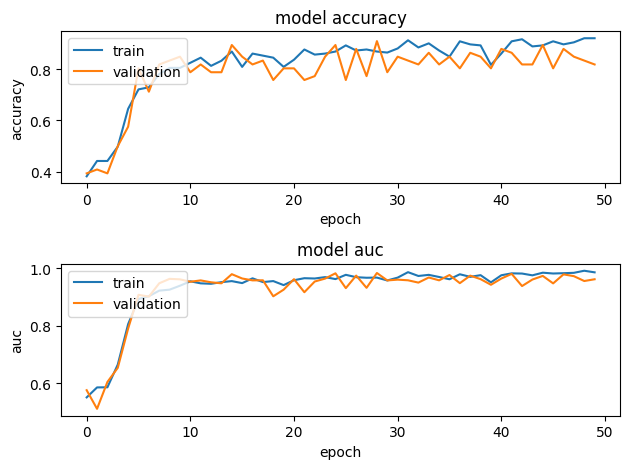

In [66]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(prediction_history.history['categorical_accuracy'])
ax1.plot(prediction_history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')
 
# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(prediction_history.history['auc_7'])
ax2.plot(prediction_history.history['val_auc_7'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping
fig.tight_layout()
 

plt.show()

## Notes
Making use of an early stop mechanism would help the model converge a lot quicker than the 50 epochs that were run here.
Only ~10 epochs are needed for a moderately accurate system.

Keeping in mind that this model may be overfit seeing as the training data set was quite small. More work could be done here to get a larger dataset and really put it to the test!